In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from scipy.sparse import csr_matrix, hstack
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100) 
pd.set_option('display.max_colwidth', None)
# Load the dataset
df = pd.read_csv('./nyt-balanced.csv', low_memory=False)



In [2]:
# Run this cell to define the selected features and the target
cat_features = [
    # 'section_name',
    'type_of_material', 
    'news_desk'
    ]
num_features = [
    'word_count', 
    # 'print_page'
    ]
text_features = [
    'abstract',
    # 'lead_paragraph'
    # "snippet",
    ]

# Convert print_page to numeric, forcing non-numeric values to NaN
df['print_page'] = pd.to_numeric(df['print_page'], errors='coerce')

# Filter out rows where print_page is NaN
df = df.dropna(subset=['print_page'])

# Fill NaN values in text columns with empty strings
df['abstract'] = df['abstract'].fillna('')
df["snippet"] = df["snippet"].fillna('')
df['lead_paragraph'] = df['lead_paragraph'].fillna('')

# Define a list of selected features
selected_features = {
    'categorical': cat_features,
    'numeric': num_features,
    'text': text_features
}



In [3]:
# # Initialize lists to store feature data and names
feature_data = []
feature_names = []

# Process categorical features
if 'categorical' in selected_features:
    onehot_encoder = OneHotEncoder(sparse=True)
    X_encoded = onehot_encoder.fit_transform(df[selected_features['categorical']])
    feature_data.append(X_encoded)
    feature_names += list(onehot_encoder.get_feature_names_out(selected_features['categorical']))

# Process numeric features
if 'numeric' in selected_features:
    numeric_features = df[selected_features['numeric']].values
    feature_data.append(csr_matrix(numeric_features))
    feature_names += selected_features['numeric']

# Process text features using TF-IDF
if 'text' in selected_features:
    tfidf_feature_names = []
    for text_feature in selected_features['text']:
        tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")  # Adjust max_features as needed
        tfidf_features = tfidf_vectorizer.fit_transform(df[text_feature])
        feature_data.append(tfidf_features)
        
        # Get feature names for TF-IDF features
        terms = tfidf_vectorizer.get_feature_names_out()
        tfidf_feature_names += [f'{text_feature}_{term}' for term in terms]
    
    feature_names += tfidf_feature_names
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=terms)



/home/phil/.pyenv/versions/3.10.8/envs/datasci200/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


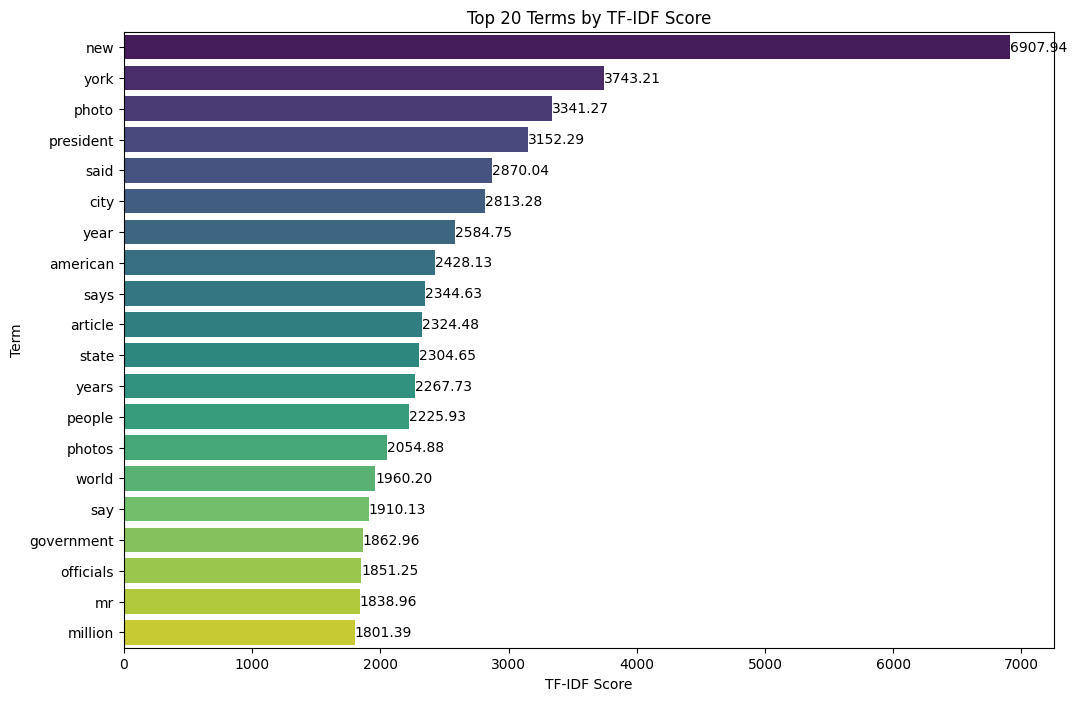

In [5]:
# Sum TF-IDF scores for each term across all documents
term_sums = tfidf_df.sum(axis=0)

# Create a DataFrame for the terms and their aggregated TF-IDF scores
term_sums_df = pd.DataFrame({'term': terms, 'tfidf': term_sums})

# Sort by TF-IDF scores and select top 30 terms
top_terms = term_sums_df.sort_values(by='tfidf', ascending=False).head(20)

# Plot the top 30 terms
plt.figure(figsize=(12, 8))
sns.barplot(x='tfidf', y='term', data=top_terms, palette='viridis')
plt.title('Top 20 Terms by TF-IDF Score')
plt.xlabel('TF-IDF Score')
plt.ylabel('Term')
for index, value in enumerate(top_terms['tfidf']):
    plt.text(value, index, f'{value:.2f}', color='black', ha="left", va="center")
plt.show()

In [6]:
# Combine all features
X_combined = hstack(feature_data)

# Convert target to binary (assuming binary classification task)
y_binary = (df['front_page'] > 0).astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_binary, test_size=0.2, random_state=42)

# Set up parameter grid for RandomizedSearchCV
param_grid = {
    'learning_rate': [
        0.01,
        0.05,
        # 0.1,
        # 0.2
        ],
    'max_depth': [
        3,
        4,
        5,
        # 6,
        # 7,
        # 8
        ],
    'min_child_weight': [1,
                         2,
                        #  3,
                        #  4
                         ],
    'subsample': [0.6,
                  0.7,
                #   0.8,
                #   0.9,
                #   1.0
                  ],
    'colsample_bytree': [0.6,
                         0.7,
                        #  0.8,
                        #  0.9,
                        #  1.0
                         ],
    'n_estimators': [100,
                     200,
                    #  300,
                    #  400,
                    #  500
                     ]
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb_model, 
    param_distributions=param_grid, 
    n_iter=50, 
    scoring='accuracy', 
    cv=3, 
    verbose=1, 
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters found: ", random_search.best_params_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/phil/.pyenv/versions/3.10.8/envs/datasci200/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [19:26:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/phil/.pyenv/versions/3.10.8/envs/datasci200/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [19:26:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/phil/.pyenv/versions/3.10.8/envs/datasci200/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [19:26:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/phil/.pyenv/versions/3.10.8/envs/datasci200/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [19:26:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

Best hyperparameters found:  {'subsample': 0.7, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.7}


In [7]:
# Get the best model
best_xgb_model = random_search.best_estimator_

# Predict and evaluate
y_pred_prob = best_xgb_model.predict_proba(X_train)[:, 1]
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_train, y_pred))



Accuracy: 0.90314375
              precision    recall  f1-score   support

           0       0.94      0.92      0.93    112736
           1       0.82      0.86      0.84     47264

    accuracy                           0.90    160000
   macro avg       0.88      0.89      0.89    160000
weighted avg       0.91      0.90      0.90    160000



In [9]:
def calculate_scores(y_true, y_pred):
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    accuracy = accuracy_score(y_true, y_pred)
    return precision, recall, f1, accuracy

calculate_scores(y_train, y_pred)

(0.8186706257649018, 0.8633420785375762, 0.8404131525018793, 0.90314375)

In [ ]:
calculate_scores(y_train, y_pred)

(0.7900969937302396, 0.3119498984427894, 0.4472961698900266, 0.77226875)

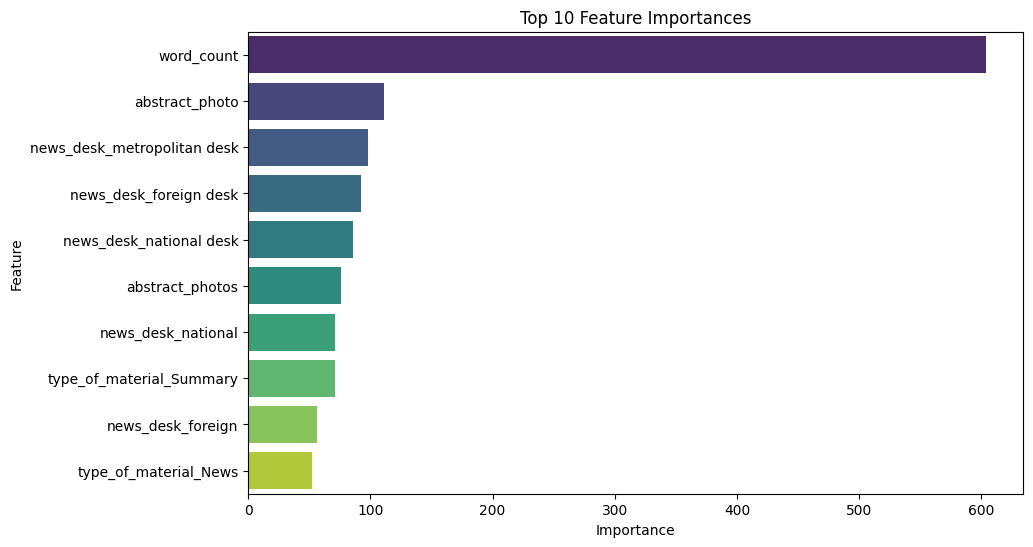

In [9]:
# Extract feature importances
importance = best_xgb_model.get_booster().get_score(importance_type='weight')
importance_df = pd.DataFrame({
    'Feature': [feature_names[int(k[1:])] if k.startswith('f') else k for k in importance.keys()],
    'Importance': importance.values()
})

# Sort by importance and select top 10
top_features = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot feature importances with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 10 Feature Importances')
plt.show()
